# Multifactor Libor Market MonteCarlo Model (part 2)
## Pricing a Swaption Receiver

In this notebook, we continue from where we left in part 1 where we assumed all forward rates are driven by the same Brownian motion, and write a multifactor Libor Market Model. 

We use it to price an atm Swaption Receiver, with a 1 year maturity and strike at 3.5%, to enter into a 5yr IRSwap with current fixed rate at 3.5%. 

The data for this exercise comes again from Fixed Income Securities, Pietro Veronesi, page 779. Data includes the volatility of forward rates, estimated by taking the standard deviation of the change in the log of forward rates as well as the principal components of the change in log forward rates.

Together with the data, Pietro also provided two solutions in example 22.7 at page 780: the swaption receiver was priced with a multifactor LMM and a single factor LMM respectively at $0.52$ and $0.60$ (per 100 principal). http://pietroveronesi.org/teaching/FIS/

When running our LMM algo we found the following values for the Swaption Receiver:

Swaption Receiver with a multifactor LMM: 0.54806 vs. 0.52 in the book 

Swaption Receiver with a single factor LMM: 0.64 vs 0.60 in the book

We used 10,000 simulation and 12 monthly steps

The multifactor LMM generates a lower price. Although the volatility of forward rates is the same, Pietro Veronesi noted that the single factor, with a perfect correlation across all forward rates, implies higher volatility of the bond price, $Z(T_0,T_M)$, as all forward rates tend to move together. The multifactor LMM, where forward rates are not perfectly correlated across maturities, generates a lower volatility of the bond price and so calculates a lower price.

The algo we use in the simulation is also provided in the book at page 778, and we report it below.

$$ f^{s}_n(t+dt,T_{i},T_{i+1}) = f^{s}_n(t,T_{i},T_{i+1}) e^{m^{s}_{i+1}(t)dt+\sum_{k=1}^{3}S_k(T_{i+1}-t)\sqrt{dt}\epsilon^{s}_{t,k}} $$

where:
$$ m^{s}_{i+1}(t) = \sum_{j=i^-}^{i} \frac{0.25f^{s}_n(t,T_{j},T_{j+1})\sum_{k=1}^{3} S_k(T_{i+1}-t)S_k(T_{j+1}-t)}{f^{s}_n(t,T_{j},T_{j+1})} -\sum_{k=1}^{3} \frac{1}{2}S_k(T_{i+1}-t)^{2}$$

- $\epsilon_{t,k}$ : are now three independent ~$N(0,1)$
- $s$ : is the simulation number
- $i^{-}$ : is the option maturity, which is year 1 in our case
- $i$ : are the times thereafter, and 
- $k$ : are the three principal component factors 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Let's load the LMM algos previously prepared.
from LMM_Functions import *

Let's read our data set:

In [3]:
ForwardRates = pd.read_csv ('Exercise_22.csv', index_col=False)
print (ForwardRates.head(2))
print (ForwardRates.tail(2))
size = len(ForwardRates)

   Maturity        DF  FwdRate_qc  FwdRateVol  FactorS1Vol  FactorS2Vol  \
0      0.25  0.993335    0.026839     0.41729      0.27915     -0.27035   
1      0.50  0.987306    0.024426     0.42793      0.35810     -0.21802   

   FactorS3Vol  
0      0.14192  
1      0.08038  
    Maturity        DF  FwdRate_qc  FwdRateVol  FactorS1Vol  FactorS2Vol  \
23      6.00  0.800106    0.049478     0.14557      0.10858      0.09092   
24      6.25  0.790226    0.050011     0.14381      0.10493      0.09159   

    FactorS3Vol  
23      0.02604  
24      0.02920  


In [4]:
print (ForwardRates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
Maturity       25 non-null float64
DF             25 non-null float64
FwdRate_qc     25 non-null float64
FwdRateVol     25 non-null float64
FactorS1Vol    25 non-null float64
FactorS2Vol    25 non-null float64
FactorS3Vol    25 non-null float64
dtypes: float64(7)
memory usage: 1.4 KB
None


We prepare the volatility vectors of the forward rates.



In [5]:
# Vol_Fwd_Rate_S are the S[] in the algo above

Vol_Fwd_Rate_S  =  np.asarray(ForwardRates.FwdRateVol)
Vol_Factor_S1   =  np.asarray(ForwardRates.FactorS1Vol)
Vol_Factor_S2   =  np.asarray(ForwardRates.FactorS2Vol)
Vol_Factor_S3   =  np.asarray(ForwardRates.FactorS3Vol)

Vol_Fwd_Rate_S_Squared  =  Vol_Fwd_Rate_S**2
Vol_Factor_Sum_Squared  =  Vol_Factor_S1**2+Vol_Factor_S2**2+Vol_Factor_S3**2

Let's look at the 3 PCA factors now

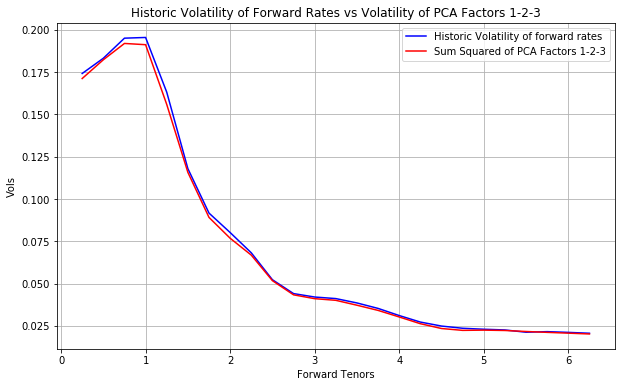

In [6]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:size], Vol_Fwd_Rate_S_Squared, lw=1.5, color='blue', label ='Historic Volatility of forward rates')
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_Sum_Squared, lw=1.5,   color='red', label ='Sum Squared of PCA Factors 1-2-3')
plt.legend()
plt.xlabel('Forward Tenors')  
plt.ylabel('Vols')
plt.grid(True)
plt.title("Historic Volatility of Forward Rates vs Volatility of PCA Factors 1-2-3");
plt.show()

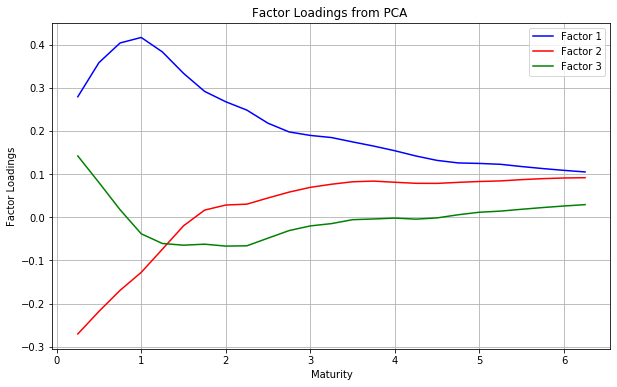

In [7]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_S1, lw=1.5, color='blue', label ='Factor 1')
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_S2, lw=1.5,   color='red', label ='Factor 2')
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_S3, lw=1.5,   color='green', label ='Factor 3')

plt.legend()
plt.xlabel('Maturity')  
plt.ylabel('Factor Loadings')
plt.grid(True)
plt.title("Factor Loadings from PCA ");
plt.show()

We are ready now to write the simulations!

The rates are simulated monthy 

In [8]:
# ******************************************
# Do not change the following values 
# ******************************************
OptionMaturity  = 1   # The model can only deal with an option maturity at 1 year!  
SimulationPaths = 12.0# In months. the maturity of the options! 

In [9]:
'''The maturity of the underlying fixed income security. So if today you want to price an option on a ZCB 
with a maturity of 3 years when the option matures, Maturity is 4 (one year after the option is exercised). 
'''
Maturity        = 6    

''' 
the number of forward rates that we are simulating.
The model is set up to simulate quarterly compounded forward rates, with four forward rates per year. 
So if the underlying matures at year 4, you need to simulate (6-1) * 4 = 20 forward rates! 
These are the 12 forward rates, required to build the Discount Factor curve from when the option matures. '''
No_of_fwd_rates = (Maturity - OptionMaturity) * 4 

In [10]:
''' 
Do not increase the number of simulations. The model is slow. We have not optimized the runs. With 10,000 it takes 
around 5 minutes. 
'''
No_of_Simulations = 10000 # simulations

In [11]:
'''We will price a Swap Receiver with the following strike:'''
Swaption_Strike = 0.035

'''The following vectors will contain the Payoff of the Swap Receiver as well a ZCB maturing at year 6'''
ZCB_Value         = np.zeros(No_of_Simulations)
Swap_Value        = np.zeros(No_of_Simulations)

ZCB_Value_with_Correlation = np.zeros(No_of_Simulations)
Swap_Value_with_Correlation= np.zeros(No_of_Simulations)

## Independent Forward Rates

In [12]:
'''Prepare a matrix of uncorrelated gaussian distributed numbers (with mean = 0 and sd = 1)  '''
npr.seed(1500)
StandardNormal = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
StandardNormal.shape

(12, 10000)

In [13]:
# The current Forward rates
'''
Note that the first entry is the same as the current spot rate. 
The rates are compounded on a quarterly basis, all with tenors of 0.25 months.
We will ONLY need to simulate the forward rates starting from the period after the option matures. 
This is because to calcuate the option payoff, we need to calculate the Discounting Factors from after the option expires.
'''
FRqc    = np.asarray(ForwardRates.FwdRate_qc)

In [14]:
# Create a lower Diagonal Matrix
s           = (No_of_fwd_rates,No_of_fwd_rates)
DriftMatrix = np.ones(s) 
DriftMatrix = np.tril(DriftMatrix, k=0)

In [15]:
for j in range(0, No_of_Simulations):
    '''
    The option expires at the 4th quarter. 
    We simulate the forward rates starting from the period following the time the option expires
    '''
    oldFRqc    = FRqc[4:-1]  
        
    for i in range(0,int(SimulationPaths)):
        dt                  = i/float(SimulationPaths)
                        
        DriftMatrix_FwdRates= DriftMatrix * 0.25*oldFRqc/(1+oldFRqc*0.25)
        VolFwdRate_toUpdate = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Fwd_Rate_S)

        # outer product of the Fwd Rate volatilities         
        temp = np.multiply.outer(VolFwdRate_toUpdate[4:-1], VolFwdRate_toUpdate[4:-1])        
        
        DriftMatrix_FwdRates_Vol = DriftMatrix_FwdRates*temp
        mu      = (DriftMatrix_FwdRates_Vol.sum(axis=1)-0.5*VolFwdRate_toUpdate[4:-1]**2)*1/float(SimulationPaths)
        mu      = np.asarray(mu)
        
        vol     = VolFwdRate_toUpdate[4:-1]*StandardNormal[i,j]
        vol     = np.asarray(vol)
    
        muDrift = mu + vol*np.sqrt(1/float(SimulationPaths))
                
        NewFRqc = oldFRqc*np.exp(muDrift)
        oldFRqc = NewFRqc
        
    
    # Valuing the ZCB with the simulated forward rates
    ZCB_Value[j]  = ZCB(oldFRqc)
    
    # Valuing the Swaption with the simulated forward rates
    Swap_Value[j] = SwapValue(oldFRqc, Swaption_Strike)

In [16]:
# Prepare the forward and spot rates from the last simulation at the time when the options expire.
spot, forward = CC_Spot_and_Forward(oldFRqc)

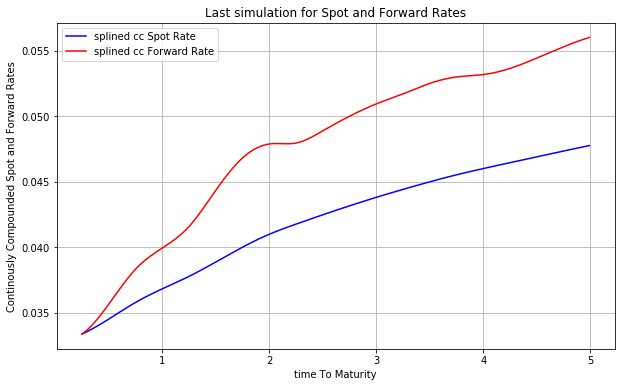

In [17]:
Maturities = np.arange (0.25, 5, 0.01)

plt.figure(figsize=(10,6))
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], spot), lw=1.5, color='blue', label ='splined cc Spot Rate')
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], forward), lw=1.5,   color='red', label ='splined cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation for Spot and Forward Rates");
plt.show()

In [30]:
print ("the Price of a Swaption Receiver with a single factor LMM is:", \
       np.round(np.mean(np.maximum(Swap_Value,0)) * ForwardRates.DF[3]*100,5))

the Price of a Swaption Receiver with a single factor LMM is: 0.63985


In [19]:
''' 
Reassuringly, at time T= 1yr, the average value of the ZCB maturing at T = 6yr is super close to  the Forward Price 
which is implied in the current Discount Factor
'''
print (np.round(np.mean(ZCB_Value),5))
print (np.round(ForwardRates.DF[23] / ForwardRates.DF[3],4))

0.81967
0.8198


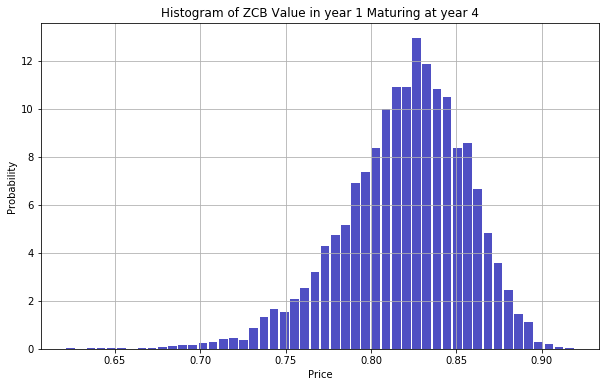

In [20]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=ZCB_Value, density = True, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Probability')
plt.title('Histogram of ZCB Value in year 1 Maturing at year 4')
plt.show()

## Multifactor Forward Rates

In [21]:
'''Prepare a matrix of uncorrelated gaussian distributed numbers (with mean = 0 and sd = 1)  for the three PCA Factors'''
npr.seed(1500)
StandardNormal1 = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
StandardNormal2 = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
StandardNormal3 = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
print(StandardNormal1.shape)

(12, 10000)


In [22]:
for j in range(0, No_of_Simulations):
    '''The option expires at the 4th quarter
    We simulate the forward rates starting from the period following the time the option expires '''    
    oldFRqcCorr = FRqc[4:-1] 
        
    for i in range(0,int(SimulationPaths)):
        dt                      = i/float(SimulationPaths)
        
        DriftMatrix_FwdRates    = DriftMatrix * 0.25*oldFRqcCorr/(1+oldFRqcCorr*0.25)               
        
        Vol_Factor_S1_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Factor_S1)
        Vol_Factor_S2_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Factor_S2)
        Vol_Factor_S3_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Factor_S3)        
        
        size      = len(Vol_Factor_S1_toUpdate[4:-1])
        PSAComp   = np.vstack((Vol_Factor_S1_toUpdate[4:-1],Vol_Factor_S2_toUpdate[4:-1], Vol_Factor_S3_toUpdate[4:-1])) 
        s         = (size,size)
        PSAMatrix = np.zeros(s) 
        for ki in range(0, size):
            for kj in range(0, size):
                PSAMatrix[kj,ki] = np.dot(PSAComp[:,kj], PSAComp[:,ki])
        
        
        DriftMatrix_FwdRates_Vol = DriftMatrix_FwdRates*PSAMatrix
        v       = Vol_Factor_S1_toUpdate[4:-1]**2 + Vol_Factor_S2_toUpdate[4:-1]**2 + Vol_Factor_S3_toUpdate[4:-1]**2
        muCorr  = (DriftMatrix_FwdRates_Vol.sum(axis=1) - 0.5*v)*1/float(SimulationPaths)             
        muCorr  = np.asarray(muCorr)
        
        volCorr = Vol_Factor_S1_toUpdate[4:-1]*StandardNormal1[i,j] + \
                  Vol_Factor_S2_toUpdate[4:-1]*StandardNormal2[i,j] + \
                  Vol_Factor_S3_toUpdate[4:-1]*StandardNormal3[i,j]         

        volCorr     = np.asarray(volCorr)                
        muCorrDrift = muCorr + volCorr * np.sqrt(1/float(SimulationPaths))
        
        NewFRqcCorr = oldFRqcCorr  * np.exp(muCorrDrift)
        oldFRqcCorr = NewFRqcCorr
        
    # Valuing the ZCB with the simulated forward rates
    ZCB_Value_with_Correlation[j]  = ZCB(oldFRqcCorr)
    
    # Valuing the Swaption with the simulated forward rates
    Swap_Value_with_Correlation[j] = SwapValue(oldFRqcCorr, Swaption_Strike)

In [23]:
# Prepare the forward and spot rates from the last simulation at the time when the options expire.
spotCorr, forwardCorr = CC_Spot_and_Forward(oldFRqcCorr)

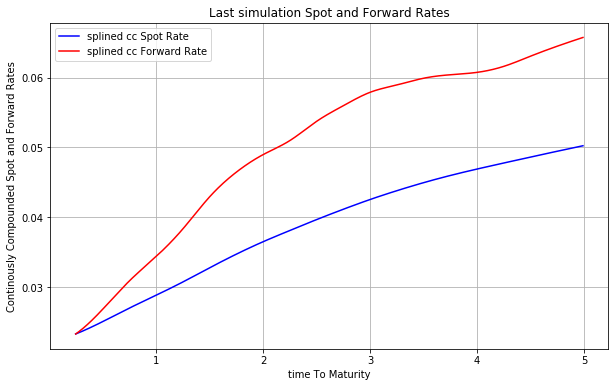

In [24]:
Maturities = np.arange (0.25, 5, 0.01)

plt.figure(figsize=(10,6))
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], spotCorr), lw=1.5, color='blue', label ='splined cc Spot Rate')
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], forwardCorr), lw=1.5,   color='red', label ='splined cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation Spot and Forward Rates");
plt.show()

In [28]:
print ("the Price of a Swaption Receiver with a multi factor LMM is:", \
       np.round(np.mean(np.maximum(Swap_Value_with_Correlation,0)) * ForwardRates.DF[3]*100,5))

the Price of a Swaption Receiver with a multi factor LMM is : 0.54806


In [26]:
''' 
Reassuringly, at time T= 1yr, the average value of the ZCB maturing at T = 6yr is super close to  the Forward Price 
which is implied in the current Discount Factor
'''
print (np.round(np.mean(ZCB_Value_with_Correlation),4))
print (np.round(ForwardRates.DF[23] / ForwardRates.DF[3],4))

0.8197
0.8198


Let's look now at the volatility of the bond price, $Z(T_0,T_M)$.

On the left below is the case with a single factor LMM, where notice more price volatility (just a bit more) vs the chart on the right, which explains the lower price with a multifactor LMM. 

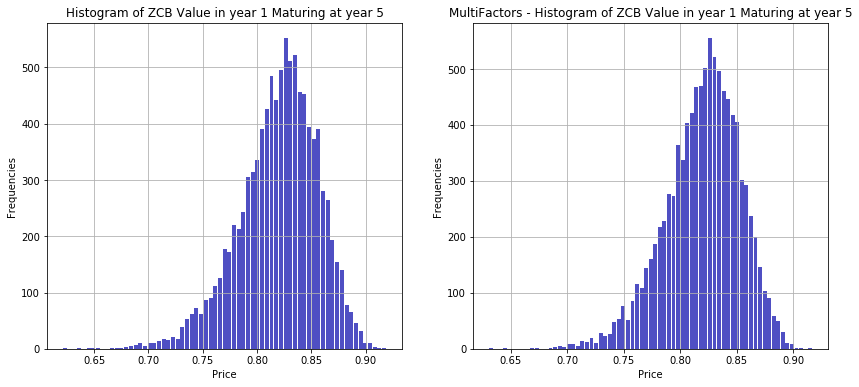

In [27]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(ZCB_Value, density = False, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
#plt.ylim(0, 14)
plt.ylabel('Frequencies')
plt.title('Histogram of ZCB Value in year 1 Maturing at year 5')


plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(x=ZCB_Value_with_Correlation, density = False, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
#plt.ylim(0, 14)
plt.ylabel('Frequencies')
plt.title('MultiFactors - Histogram of ZCB Value in year 1 Maturing at year 5')

plt.show()